### Imports

In [1]:
import numpy as np
from math import log
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
from itertools import zip_longest

### Whether all the data in a attribute is of same type

In [2]:
def pure_data(data):
    label_column = data[:, -1]
    u_val = np.unique(label_column)
    if len(u_val) == 1:
        return True
    else:
        return False

In [3]:
def classifyy(data):
    label_column = data[:, -1]
    u_val, counts_u_val = np.unique(label_column, return_counts=True)
    index = counts_u_val.argmax()
    classification = u_val[index]
#     print(u_val,"-" ,counts_u_val)
    return classification

### To find the value to split data in 2 halves

In [4]:
def find_best_val_to_split(data):
    best_attr_split = {}
    _, n_columns = data.shape
    # print( _, n_columns)
    for cols in range(n_columns - 1):  
        values = data[:, cols]
        u_valss = np.unique(values)
        type_of_feature = FEATURE_TYPES[cols]
        if type_of_feature == "continuous":
            best_attr_split[cols] = []
            for index in range(len(u_valss)):
                if index != 0:
                    current_value = u_valss[index]
                    previous_value = u_valss[index - 1]
                    split_val = (current_value + previous_value) / 2
                    best_attr_split[cols].append(split_val)

        elif len(u_valss) > 1:
            best_attr_split[cols] = u_valss
    return best_attr_split

### Splitting data into 2 parts to form tree structure

In [5]:
def split_data(data, split_column, split_value):
    split_column_values = data[:, split_column]
    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        df_left = data[split_column_values <= split_value]
        df_right = data[split_column_values >  split_value]
    # feature is categorical   
    else:
        df_left = data[split_column_values == split_value]
        df_right = data[split_column_values != split_value]
    
    return df_left, df_right   

### To find lowest entropy of columns

In [6]:
# def misclassification(data,label):
#     label_column = data[:, -1]
#     _, counts = np.unique(label_column, return_counts=True)

#     q_value = counts / counts.sum()
#     entropy = -999
#     for x in q_value:
#         if entropy < x:
#             entropy = x
#     return entropy

# def gini_index(data,label):
#     label_column = data[:, -1]
#     _, counts = np.unique(label_column, return_counts=True)

#     q_value = counts / counts.sum()
#     entropy = 0
#     for x in q_value:
#         entropy = x * x
#     return entropy

def calculate_entropy(data,label):
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)
    q_value = counts / counts.sum()
    entropy = sum(q_value * -np.log2(q_value))
    return entropy

    # Gini index
    # entropy=2*q_value*(1-q_value)
    # return entropy[0]

    # misclassification rate
    # entropy=min(q_value[0],1-q_value[0])
    # return entropy

In [7]:
def total_entropy(df_left, df_right1):
    df_right = df_right1[:]
    n = len(df_left) + len(df_right)
    d_left = len(df_left) / n
    d_right = len(df_right) / n

    # tot_entr =  (d_left * calculate_entropy(df_left) 
    #                   + d_right * calculate_entropy(df_right))
    tot_entr =  (d_left * calculate_entropy(df_left,label) 
                      + d_right * calculate_entropy(df_right,label))
    
    return tot_entr

In [8]:
def determine_best_split(data, best_attr_split):
    tot_entr = 9999
    for cols in best_attr_split:
        for value in best_attr_split[cols]:
            df_left, df_right = split_data(data, split_column=cols, split_value=value)
            current_tot_entr = total_entropy(df_left, df_right)

            if current_tot_entr <= tot_entr:
                tot_entr = current_tot_entr
                col_break = cols
                value_break = value
    
    return col_break, value_break                         

In [9]:
def determine_type_of_feature(df):
    feature_types = []
    threshold_for_categorical = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]
            if (isinstance(example_value, str)) or (len(unique_values) <= threshold_for_categorical):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [10]:
count=0
def Make_dec_tree(df, counter=0, min_samples=2, max_depth=5):
    global count
    count+=1
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    if (pure_data(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classifyy(data)
        return classification

    else:    
        counter += 1
        best_attr_split = find_best_val_to_split(data)
        split_column, split_value = determine_best_split(data, best_attr_split)
        data_below, data_above = split_data(data, split_column, split_value)
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
        else:
            question = "{} = {}".format(feature_name, split_value)
        sub_tree = {question: []}
        yes_answer = Make_dec_tree(data_below, counter, min_samples, max_depth)
        no_answer = Make_dec_tree(data_above, counter, min_samples, max_depth)
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree
    
def classification_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, compare, value = question.split(" ")

    if compare == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    if not isinstance(answer, dict):
        return answer
    
    else:
        rest_tree = answer
        return classification_example(example, rest_tree)


def all_calculations(df, tree):
    correct,TP,FP,FN,TN=0,0,0,0,0
    # global correct,TP,FP,FN
    df["classification"] = df.apply(classification_example, args=(tree,), axis=1)
    # print(df["classification"])
    for value, left in zip_longest(df["classification"],df['left']):
        if value == left:
            if left == 0:
                TN += 1
            else:
                TP += 1
    else:
        if left == 0:
            FP += 1
        else:
            FN += 1
            
    x = (TP+FN)
    y = (TP+FP)
    if x:
        rc=TP/x
    if y:
        pc=TP/y
    f1=(2*rc*pc)/(rc+pc)
    df["classification_correct"] = df["classification"] == df["left"]  
    accuracy = df["classification_correct"].mean()
    return accuracy,TP,FP,FN,TN,rc,pc,f1

def predicts(df, tree):
    df["classification"] = df.apply(classification_example, args=(tree,), axis=1)
    # print(df["classification"])
#     df["classification_correct"] = df["classification"] == df["left"]  
    return df["classification"] 

df = pd.read_csv("../input_data/train1.csv")
# df = df.rename(columns={"left": "label"})
# random.seed(0)
label = "left"

train_df, test_df = train_test_split(df, test_size=0.2)
tree = Make_dec_tree(train_df, max_depth=25)
accuracy,TP,FP,FN,TN,rc,pc,f1= all_calculations(test_df, tree)
# TP = calculate_accuracy(test_df, tree)
# FP = calculate_accuracy(test_df, tree)
# FN = calculate_accuracy(test_df, tree)
pp = predicts(test_df, tree)
# print(pp)
# question = list(tree.keys())[0]
# print(question)
# pprint(tree, width=100)
# print(tree)
# print("\nThe accuracy is: ", accuracy)
# print(TP)
# print(FP)
# print(FN)
# print(TN)
# print("\nRecall: ", rc)
# print("\nPrecision: ", pc)
# print("\nF1-Score: ", f1)




/home/keshu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/keshu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/keshu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

In [11]:
# xx=sns.pairplot(train_df, hue="salary")

In [12]:
def node_count():
    global count
    count = 0
    acc=[]
    acctrain=[]
    noofnodes=[]
    depth=[]
    for i in range(5):
        count =0
        t=Make_dec_tree(df,0,2,i+1)
        noofnodes.append(count)
        depth.append(i+1)
        accu,TP,FP,FN,TN,rc,pc,f1= all_calculations(test_df, t)
        accu1,tp1,fp1,fn1,tn1,rc1,pc1,f11=all_calculations(train_df,t)
        acc.append(accu)
        acctrain.append(accu1)
        
    return acc,noofnodes,depth,acctrain
        
    

In [13]:
acc,noc,det,acctrain = node_count()

/home/keshu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/keshu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
noc

[3, 7, 13, 25, 43]

In [15]:
acc

[0.8193950177935944,
 0.847864768683274,
 0.951067615658363,
 0.9657473309608541,
 0.9737544483985765]

In [16]:
acctrain

[0.8211345939933259,
 0.8482758620689655,
 0.9492769744160178,
 0.9666295884315906,
 0.974860956618465]

### Plot of No. of nodes vs Error

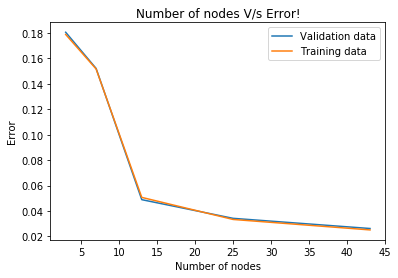

In [17]:
import matplotlib.pyplot as plt 
  
x = noc 
y = acc
z = acctrain
y1=[]
y2=[]
for xx in y:
    y1.append(1-xx)
for kk in z:
    y2.append(1-kk)
plt.plot(x, y1, label = "Validation data")  
plt.plot(x, y2, label = "Training data")  
plt.xlabel('Number of nodes') 
plt.ylabel('Error') 
plt.legend() 
plt.title('Number of nodes V/s Error!') 
plt.show() 

### Plot of Depth vs Error

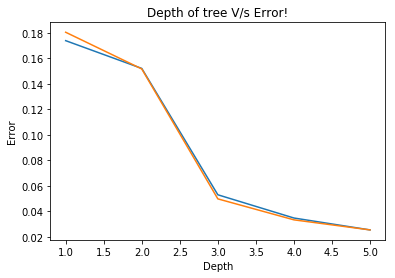

In [24]:
import matplotlib.pyplot as plt 

x = det 
y = acc
y1=[]
y2=[]
for xx in y:
    y1.append(1-xx)
for kk in z:
    y2.append(1-kk)
plt.plot(x, y1, label = "Validation data")  
plt.plot(x, y2, label = "Training data")  
plt.xlabel('Depth') 
plt.ylabel('Error') 

plt.title('Depth of tree V/s Error!') 
plt.show() 